In [60]:
import pandas as pd
import optuna
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFdr, f_classif
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from numpy import mean, std

In [92]:
clean_df = pd.read_csv('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/data/cleaned_data.csv')
clean_df.head()

,name_0,name_1,name_2,name_3,name_4,name_5,name_6,name_7,name_8,name_9,...,ingre_191,ingre_192,ingre_193,ingre_194,ingre_195,ingre_196,ingre_197,ingre_198,ingre_199,Cuisine
0,-0.004312,-0.002012,-0.002159,-0.023006,0.005757,-0.022049,0.005636,0.019611,-0.009523,-0.005058,...,-0.059784,-0.079434,-0.042745,0.070466,0.146786,0.037995,-0.170187,-0.032722,-0.072724,mexican
1,-0.001863,-0.036694,-0.032176,-0.033543,0.017696,0.036794,-0.042318,-0.002558,0.038946,0.006620,...,-0.036531,-0.049942,-0.026416,0.043427,0.092074,0.022960,-0.106228,-0.016947,-0.047153,mexican
2,0.009742,0.004224,0.019151,0.000291,-0.032288,-0.023436,-0.018530,0.037181,-0.005550,-0.006011,...,-0.060001,-0.079585,-0.042589,0.068580,0.142211,0.036959,-0.167378,-0.033069,-0.071908,mexican
3,0.046860,0.000995,-0.004505,-0.002641,0.035574,-0.009168,-0.022422,-0.033187,0.020465,0.032154,...,-0.064125,-0.086882,-0.047221,0.074757,0.152996,0.039335,-0.180329,-0.031542,-0.076776,mexican
4,-0.007964,-0.009498,-0.018710,0.008358,0.037844,0.005159,0.037246,-0.017101,-0.030500,0.010756,...,-0.054571,-0.079612,-0.039428,0.063985,0.138365,0.036532,-0.161366,-0.030667,-0.065822,mexican


In [93]:
X = clean_df.iloc[:,:-1]
y = clean_df['Cuisine']

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Feature filtering
fdr = SelectFdr(score_func=f_classif, alpha = 0.01)
fdr.fit(X, y)
X_fdr = fdr.transform(X)

# Check the number of features and the names of features selected by fdr
feat_labels = list(clean_df.columns)
i = 0
for feature_list_index in fdr.get_support(indices=True):
    i += 1
#    print(feat_labels[feature_list_index])
print('Number of features selected: ',i)


# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_fdr, y, test_size=0.2, random_state=42)
cv = KFold(n_splits=10, random_state=42, shuffle=True)

Number of features selected:  186


## SVM

In [96]:
svc = SVC(C=1000, gamma=0.0001, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('F1 score of SVC : %.3f' % (mean(f1_score(y_test, y_pred, average='weighted'))))
print('In-sample testing accuracy of SVC : %.3f ' % accuracy_score(y_test, y_pred))

F1 score of SVC : 0.642
In-sample testing accuracy of SVC : 0.635 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


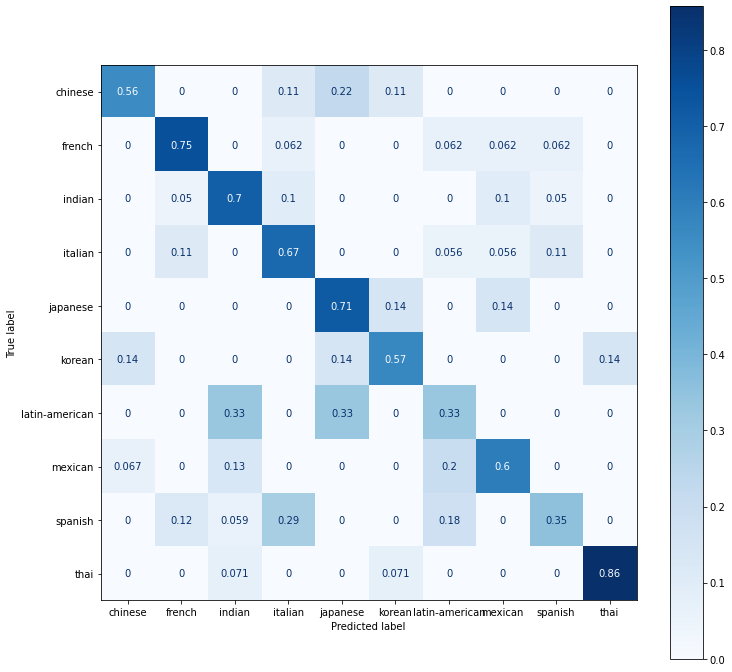

In [97]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(svc, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize='true')  
plt.show()

In [95]:
# Hyperparameter tuning
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.120 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.470 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.390 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.340 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.340 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.450 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.190 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.400 total time=   0.0s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.390 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.450 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.450 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.480 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.330 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.260 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.290 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.390 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.360 total time=   0.0s
[CV 1/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.250 total time=   0.0s
[CV 2/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.270 total time=   0.0s
[CV 3/5] END ...C=1, gamma=0

[CV 4/5] END .C=10, gamma=0.001, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 5/5] END .C=10, gamma=0.001, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.340 total time=   0.0s
[CV 2/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.350 total time=   0.0s
[CV 3/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.350 total time=   0.0s
[CV 4/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.350 total time=   0.0s
[CV 5/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.300 total time=   0.0s
[CV 1/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.110 total time=   0.0s
[CV 2/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 3/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 4/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 5/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 1/5] END C=10, gamma=0.0

[CV 3/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.170 total time=   0.0s
[CV 4/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.210 total time=   0.0s
[CV 5/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.160 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.260 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.180 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.220 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.270 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.260 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.470 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.390 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.340 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.340 total time=   0.0s
[CV 5/5] END ....C=1000, gam

## Random Forest

In [100]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=7, min_samples_leaf=4)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('F1 score of Random Frorest : %.3f' % (mean(f1_score(y_test, y_pred, average='weighted'))))
print('In-sample testing accuracy of Random Forest : %.3f ' % accuracy_score(y_test, y_pred))

F1 score of Random Frorest : 0.493
In-sample testing accuracy of Random Forest : 0.508 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


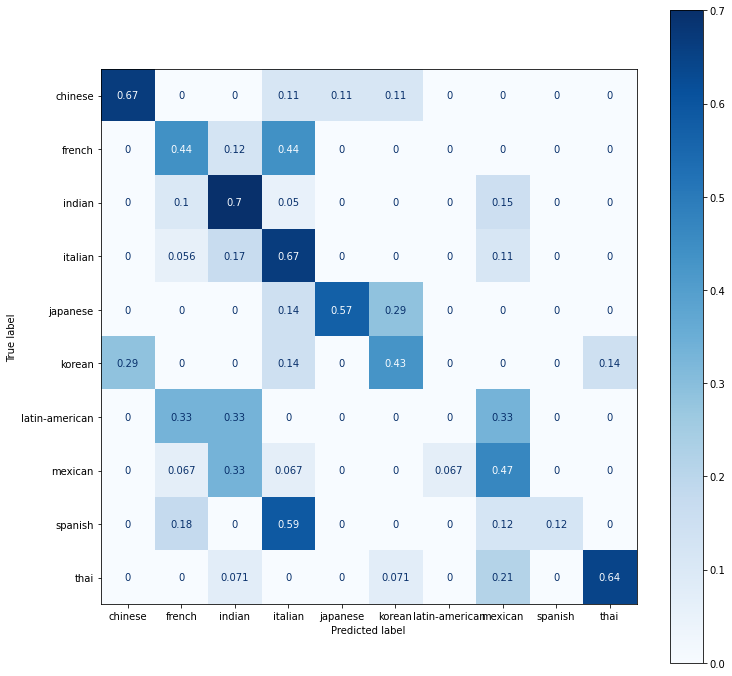

In [101]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(rfc, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize='true')  
plt.show()

In [99]:
# Hyperparameter tuning with optuna
# Reference: https://stackoverflow.com/questions/69482251/random-forest-hyper-parameters-tuning-with-panel-data-in-python
# https://stats.stackexchange.com/questions/36165/does-the-optimal-number-of-trees-in-a-random-forest-depend-on-the-number-of-pred

def rf_objective(trial,X=X,y=y):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform (test_x)
    
    param = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 75, 100, 150]),
        "max_depth" : trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int('min_samples_split', 3, 10),
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 3, 10),
    }
    model = RandomForestClassifier(**param)  
    model.fit(train_x,train_y)
    preds = model.predict(test_x)
    accuracy = accuracy_score(test_y, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(rf_objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial parameters:", study.best_trial.params)

[I 2022-09-14 16:35:36,756] A new study created in memory with name: no-name-8d4fbd1e-21f4-4364-9462-e5c8e8b0e643
[I 2022-09-14 16:35:36,991] Trial 0 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5714285714285714.
[I 2022-09-14 16:35:37,080] Trial 1 finished with value: 0.4523809523809524 and parameters: {'n_estimators': 75, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5714285714285714.
[I 2022-09-14 16:35:37,331] Trial 2 finished with value: 0.5238095238095238 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5714285714285714.
[I 2022-09-14 16:35:37,401] Trial 3 finished with value: 0.49206349206349204 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.5

[I 2022-09-14 16:35:43,166] Trial 34 finished with value: 0.5317460317460317 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.5714285714285714.
[I 2022-09-14 16:35:43,338] Trial 35 finished with value: 0.5476190476190477 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5714285714285714.
[I 2022-09-14 16:35:43,501] Trial 36 finished with value: 0.5555555555555556 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.5714285714285714.
[I 2022-09-14 16:35:43,660] Trial 37 finished with value: 0.49206349206349204 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.5714285714285714.
[I 2022-09-14 16:35:43,848] Trial 38 finished with value: 0.5238095238095238 and parameters

Number of finished trials: 50
Best trial parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4}


In [46]:
catboost = CatBoostClassifier(iterations=10)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
scores = cross_val_score(catboost, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Training accuracy of CatBoost : %.3f (std = %.3f)' % (mean(scores), std(scores)))
print('F1 score of CatBoost : %.3f' % (mean(f1_score(y_test, y_pred, average='weighted'))))
print('In-sample testing accuracy of CatBoost : %.3f ' % accuracy_score(y_test, y_pred))

Learning rate set to 0.5
0:	learn: 2.1537822	total: 34.7ms	remaining: 312ms
1:	learn: 1.9438545	total: 59ms	remaining: 236ms
2:	learn: 1.8104251	total: 81.3ms	remaining: 190ms
3:	learn: 1.7137789	total: 104ms	remaining: 155ms
4:	learn: 1.6253075	total: 126ms	remaining: 126ms
5:	learn: 1.5221790	total: 148ms	remaining: 98.5ms
6:	learn: 1.4370262	total: 170ms	remaining: 73ms
7:	learn: 1.3614027	total: 192ms	remaining: 48ms
8:	learn: 1.2824464	total: 215ms	remaining: 23.9ms
9:	learn: 1.2241142	total: 238ms	remaining: 0us
Training accuracy of CatBoost : 0.340 (std = 0.075)
F1 score of CatBoost : 0.402
In-sample testing accuracy of CatBoost : 0.405 
